### Using larger windowsizes to plot mutation rate as function of distance to CDR

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


In [3]:
def classify_shape(diff):
    if diff == -1:
        return "triangle"
    elif 0 <= diff <= 0.1:
        return "parallelogram"
    elif diff > 0.1:
        return "trapezoid"
    else:
        return np.nan

## SVs - 50kb windows 

In [12]:
def load_matching_SV_beds(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4,5, 6, 7, 8, 9,10,11,12,18]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "par_counts",
        "par_rate",
        "trap_counts",
        "trap_rate",
        "tri_counts",
        "tri_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [ ]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/50kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_SV_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.50kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SV_50kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

SV_50kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,sample1,sample2,chr,both_pairs_CDR
0,HG03710#2#CM086879.1,121750812,121800812,0,0.0,0,0.00000,1019,0.02038,HG03710#2#CM086879.1,123022959,123030439,CDR,1222148,HG04115.1,HG03710.2,chr1,True
1,HG03710#2#CM086879.1,121800812,121850812,0,0.0,0,0.00000,1020,0.02040,HG03710#2#CM086879.1,123022959,123030439,CDR,1172148,HG04115.1,HG03710.2,chr1,True
2,HG03710#2#CM086879.1,121850812,121900812,0,0.0,0,0.00000,10528,0.21056,HG03710#2#CM086879.1,123022959,123030439,CDR,1122148,HG04115.1,HG03710.2,chr1,True
3,HG03710#2#CM086879.1,121900812,121950812,0,0.0,10528,0.21056,3742,0.07484,HG03710#2#CM086879.1,123022959,123030439,CDR,1072148,HG04115.1,HG03710.2,chr1,True
4,HG03710#2#CM086879.1,121950812,122000812,0,0.0,0,0.00000,1,0.00002,HG03710#2#CM086879.1,123022959,123030439,CDR,1022148,HG04115.1,HG03710.2,chr1,True


In [9]:
# add rate for all variants
SV_50kb_df["all_counts"] = (
    SV_50kb_df["par_counts"]
    + SV_50kb_df["trap_counts"]
    + SV_50kb_df["tri_counts"]
)

SV_50kb_df["all_rate"] = SV_50kb_df["all_counts"] / 50000

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
SV_50kb_df["CDR_distance"] = -SV_50kb_df["CDR_distance"]

SV_50kb_df.head()

,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,sample1,sample2,chr,both_pairs_CDR,all_counts,all_rate
0,HG03710#2#CM086879.1,121750812,121800812,0,0.0,0,0.00000,1019,0.02038,HG03710#2#CM086879.1,123022959,123030439,CDR,-1222148,HG04115.1,HG03710.2,chr1,True,1019,0.02038
1,HG03710#2#CM086879.1,121800812,121850812,0,0.0,0,0.00000,1020,0.02040,HG03710#2#CM086879.1,123022959,123030439,CDR,-1172148,HG04115.1,HG03710.2,chr1,True,1020,0.02040
2,HG03710#2#CM086879.1,121850812,121900812,0,0.0,0,0.00000,10528,0.21056,HG03710#2#CM086879.1,123022959,123030439,CDR,-1122148,HG04115.1,HG03710.2,chr1,True,10528,0.21056
3,HG03710#2#CM086879.1,121900812,121950812,0,0.0,10528,0.21056,3742,0.07484,HG03710#2#CM086879.1,123022959,123030439,CDR,-1072148,HG04115.1,HG03710.2,chr1,True,14270,0.28540
4,HG03710#2#CM086879.1,121950812,122000812,0,0.0,0,0.00000,1,0.00002,HG03710#2#CM086879.1,123022959,123030439,CDR,-1022148,HG04115.1,HG03710.2,chr1,True,1,0.00002


### Chrom-weighted average lines, for all SVs. 50kb windows

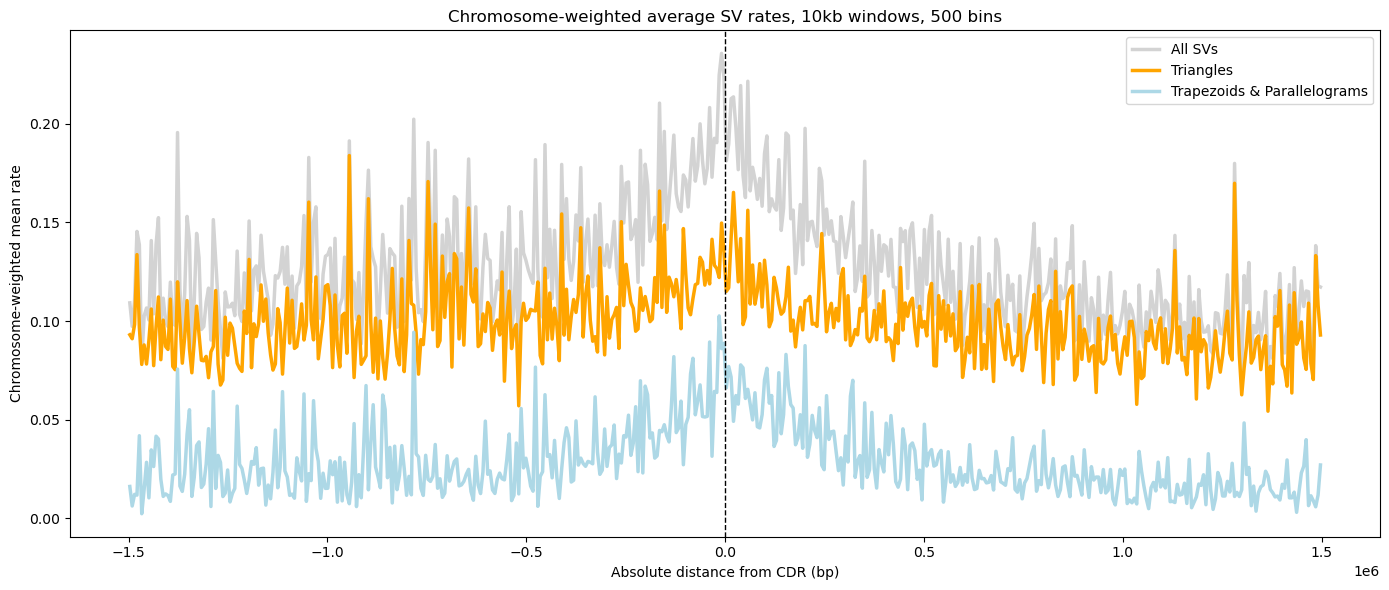

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = SV_50kb_df[SV_50kb_df["CDR_start"] != -1].copy()

# Combine trap and par rates
df["trap_par_rate"] = df["trap_rate"] + df["par_rate"]

# Bin distances
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and colors
rate_columns = ["all_rate", "tri_rate", "trap_par_rate"]
colors = ["lightgrey", "orange", "lightblue"]
labels = ["All SVs", "Triangles","Trapezoids & Parallelograms"]

# 4. Plot
plt.figure(figsize=(14,6))

for rate_col, color, label in zip(rate_columns, colors, labels):
    # Per-chromosome mean per bin
    chrom_bin_means = (
        df.groupby(["chr", "distance_bin"], as_index=False)
          .agg(mean_rate=(rate_col, "mean"))
    )
    
    # Chromosome-weighted genome average
    genome_avg = (
        chrom_bin_means.groupby("distance_bin", as_index=False)
                       .agg(mean_rate=("mean_rate", "mean"))
                       .sort_values("distance_bin")
    )
    
    plt.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color=color,
        linewidth=2.5,
        label=label
    )

# 5. Vertical line at CDR
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Absolute distance from CDR (bp)")
plt.ylabel("Chromosome-weighted mean rate")
plt.title("Chromosome-weighted average SV rates, 50kb windows, 500 bins")
plt.legend()
plt.tight_layout()
plt.show()

### SVs, 100kb windows 

In [14]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/100kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_SV_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.100kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SV_100kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

# add rate for all variants
SV_100kb_df["all_counts"] = (
    SV_100kb_df["par_counts"]
    + SV_100kb_df["trap_counts"]
    + SV_100kb_df["tri_counts"]
)

SV_100kb_df["all_rate"] = SV_100kb_df["all_counts"] / 100000

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
SV_100kb_df["CDR_distance"] = -SV_100kb_df["CDR_distance"]

SV_100kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,sample1,sample2,chr,both_pairs_CDR,all_counts,all_rate
0,HG02071#2#JBHIGJ010000042.1,121968105,122068105,0,0.0,0,0.00000,13578,0.13578,HG02071#2#JBHIGJ010000042.1,122760020,122848872,CDR,-691916,HG02071.2,NA18747.1,chr1,True,13578,0.13578
1,HG02071#2#JBHIGJ010000042.1,122068105,122168105,0,0.0,1,0.00001,7900,0.07900,HG02071#2#JBHIGJ010000042.1,122760020,122848872,CDR,-591916,HG02071.2,NA18747.1,chr1,True,7901,0.07901
2,HG02071#2#JBHIGJ010000042.1,122168105,122268105,0,0.0,1360,0.01360,5438,0.05438,HG02071#2#JBHIGJ010000042.1,122760020,122848872,CDR,-491916,HG02071.2,NA18747.1,chr1,True,6798,0.06798
3,HG02071#2#JBHIGJ010000042.1,122268105,122368105,0,0.0,0,0.00000,8653,0.08653,HG02071#2#JBHIGJ010000042.1,122760020,122848872,CDR,-391916,HG02071.2,NA18747.1,chr1,True,8653,0.08653
4,HG02071#2#JBHIGJ010000042.1,122368105,122468105,0,0.0,1,0.00001,5783,0.05783,HG02071#2#JBHIGJ010000042.1,122760020,122848872,CDR,-291916,HG02071.2,NA18747.1,chr1,True,5784,0.05784


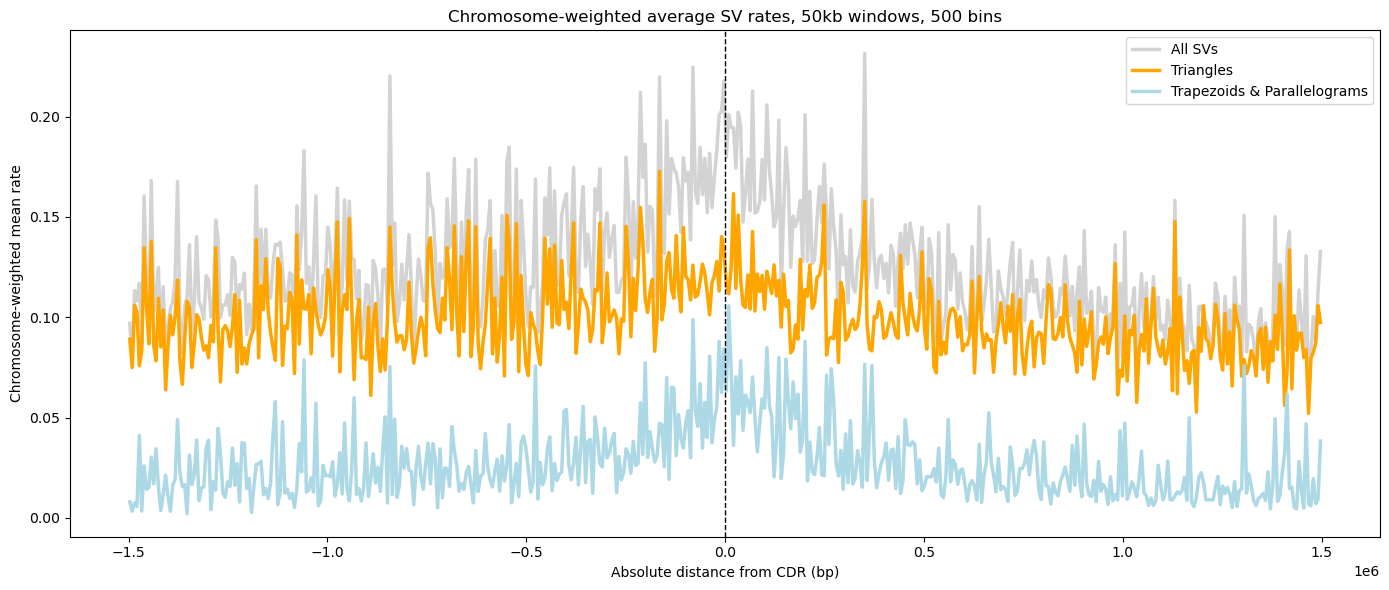

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = SV_100kb_df[SV_100kb_df["CDR_start"] != -1].copy()

# Combine trap and par rates
df["trap_par_rate"] = df["trap_rate"] + df["par_rate"]

# Bin distances
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and colors
rate_columns = ["all_rate", "tri_rate", "trap_par_rate"]
colors = ["lightgrey", "orange", "lightblue"]
labels = ["All SVs", "Triangles","Trapezoids & Parallelograms"]

# 4. Plot
plt.figure(figsize=(14,6))

for rate_col, color, label in zip(rate_columns, colors, labels):
    # Per-chromosome mean per bin
    chrom_bin_means = (
        df.groupby(["chr", "distance_bin"], as_index=False)
          .agg(mean_rate=(rate_col, "mean"))
    )
    
    # Chromosome-weighted genome average
    genome_avg = (
        chrom_bin_means.groupby("distance_bin", as_index=False)
                       .agg(mean_rate=("mean_rate", "mean"))
                       .sort_values("distance_bin")
    )
    
    plt.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color=color,
        linewidth=2.5,
        label=label
    )

# 5. Vertical line at CDR
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Absolute distance from CDR (bp)")
plt.ylabel("Chromosome-weighted mean rate")
plt.title("Chromosome-weighted average SV rates, 100kb windows, 500 bins")
plt.legend()
plt.tight_layout()
plt.show()

### SVs, 100kb windows, combining trapezoids and triangles and dropping parallelograms 

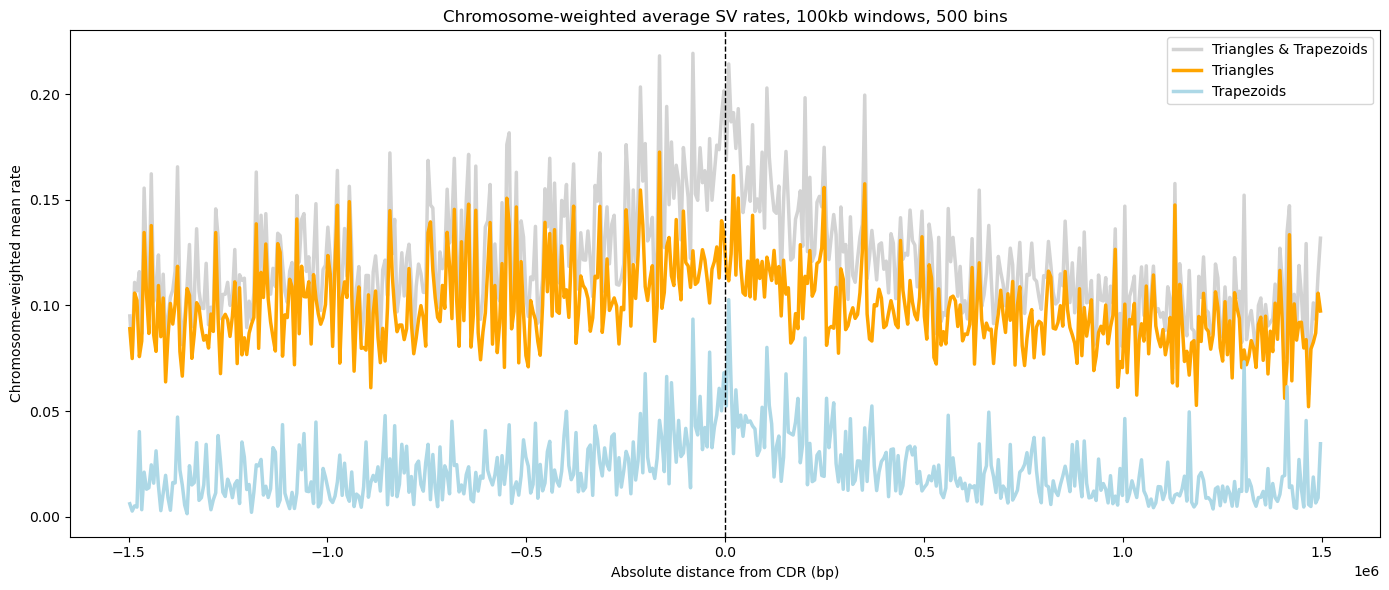

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = SV_100kb_df[SV_100kb_df["CDR_start"] != -1].copy()

# Combine trap and par rates
df["tri_trap_rate"] = df["trap_rate"] + df["tri_rate"]

# Bin distances
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and colors
rate_columns = ["tri_trap_rate", "tri_rate", "trap_rate"]
colors = ["lightgrey", "orange", "lightblue"]
labels = ["Triangles & Trapezoids", "Triangles","Trapezoids"]

# 4. Plot
plt.figure(figsize=(14,6))

for rate_col, color, label in zip(rate_columns, colors, labels):
    # Per-chromosome mean per bin
    chrom_bin_means = (
        df.groupby(["chr", "distance_bin"], as_index=False)
          .agg(mean_rate=(rate_col, "mean"))
    )
    
    # Chromosome-weighted genome average
    genome_avg = (
        chrom_bin_means.groupby("distance_bin", as_index=False)
                       .agg(mean_rate=("mean_rate", "mean"))
                       .sort_values("distance_bin")
    )
    
    plt.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color=color,
        linewidth=2.5,
        label=label
    )

# 5. Vertical line at CDR
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Absolute distance from CDR (bp)")
plt.ylabel("Chromosome-weighted mean rate")
plt.title("Chromosome-weighted average SV rates, 100kb windows, 500 bins")
plt.legend()
plt.tight_layout()
plt.show()

### Short indels, 10kb windows 

In [17]:
def load_matching_bed_aln(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4,5, 6, 7, 8, 9,10,11,12,18,19]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "par_counts",
        "par_rate",
        "trap_counts",
        "trap_rate",
        "tri_counts",
        "tri_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance",
        "aligned_bases"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):
        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )
        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [18]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/short_indels_pairwise_10kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_bed_aln(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
short_indel_10kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

short_indel_10kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,aligned_bases,sample1,sample2,chr,both_pairs_CDR
0,NA19909#2#CM094132.1,121895768,121905768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124208369,124227486,CDR,2302602,7625,HG01784.1,NA19909.2,chr1,True
1,NA19909#2#CM094132.1,121905768,121915768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124208369,124227486,CDR,2292602,10000,HG01784.1,NA19909.2,chr1,True
2,NA19909#2#CM094132.1,121915768,121925768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124208369,124227486,CDR,2282602,9901,HG01784.1,NA19909.2,chr1,True
3,NA19909#2#CM094132.1,121925768,121935768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124208369,124227486,CDR,2272602,7382,HG01784.1,NA19909.2,chr1,True
4,NA19909#2#CM094132.1,121935768,121945768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124208369,124227486,CDR,2262602,6600,HG01784.1,NA19909.2,chr1,True


In [19]:
# add rate for all variants
short_indel_10kb_df["all_counts"] = (
    short_indel_10kb_df["par_counts"]
    + short_indel_10kb_df["trap_counts"]
    + short_indel_10kb_df["tri_counts"]
)

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
short_indel_10kb_df["CDR_distance"] = -short_indel_10kb_df["CDR_distance"]

short_indel_10kb_df["tri_rate_aln_bases"] = short_indel_10kb_df["tri_counts"] / short_indel_10kb_df["aligned_bases"]
short_indel_10kb_df["par_rate_aln_bases"] = short_indel_10kb_df["par_counts"] / short_indel_10kb_df["aligned_bases"]
short_indel_10kb_df["trap_rate_aln_bases"] = short_indel_10kb_df["trap_counts"] / short_indel_10kb_df["aligned_bases"]

short_indel_10kb_df["all_rate_aln_bases"] = short_indel_10kb_df["all_counts"] / short_indel_10kb_df["aligned_bases"]
short_indel_10kb_df.head()

,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,...,aligned_bases,sample1,sample2,chr,both_pairs_CDR,all_counts,tri_rate_aln_bases,par_rate_aln_bases,trap_rate_aln_bases,all_rate_aln_bases
0,NA19909#2#CM094132.1,121895768,121905768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,7625,HG01784.1,NA19909.2,chr1,True,0,0.0,0.0,0.0,0.0
1,NA19909#2#CM094132.1,121905768,121915768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,10000,HG01784.1,NA19909.2,chr1,True,0,0.0,0.0,0.0,0.0
2,NA19909#2#CM094132.1,121915768,121925768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,9901,HG01784.1,NA19909.2,chr1,True,0,0.0,0.0,0.0,0.0
3,NA19909#2#CM094132.1,121925768,121935768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,7382,HG01784.1,NA19909.2,chr1,True,0,0.0,0.0,0.0,0.0
4,NA19909#2#CM094132.1,121935768,121945768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,6600,HG01784.1,NA19909.2,chr1,True,0,0.0,0.0,0.0,0.0


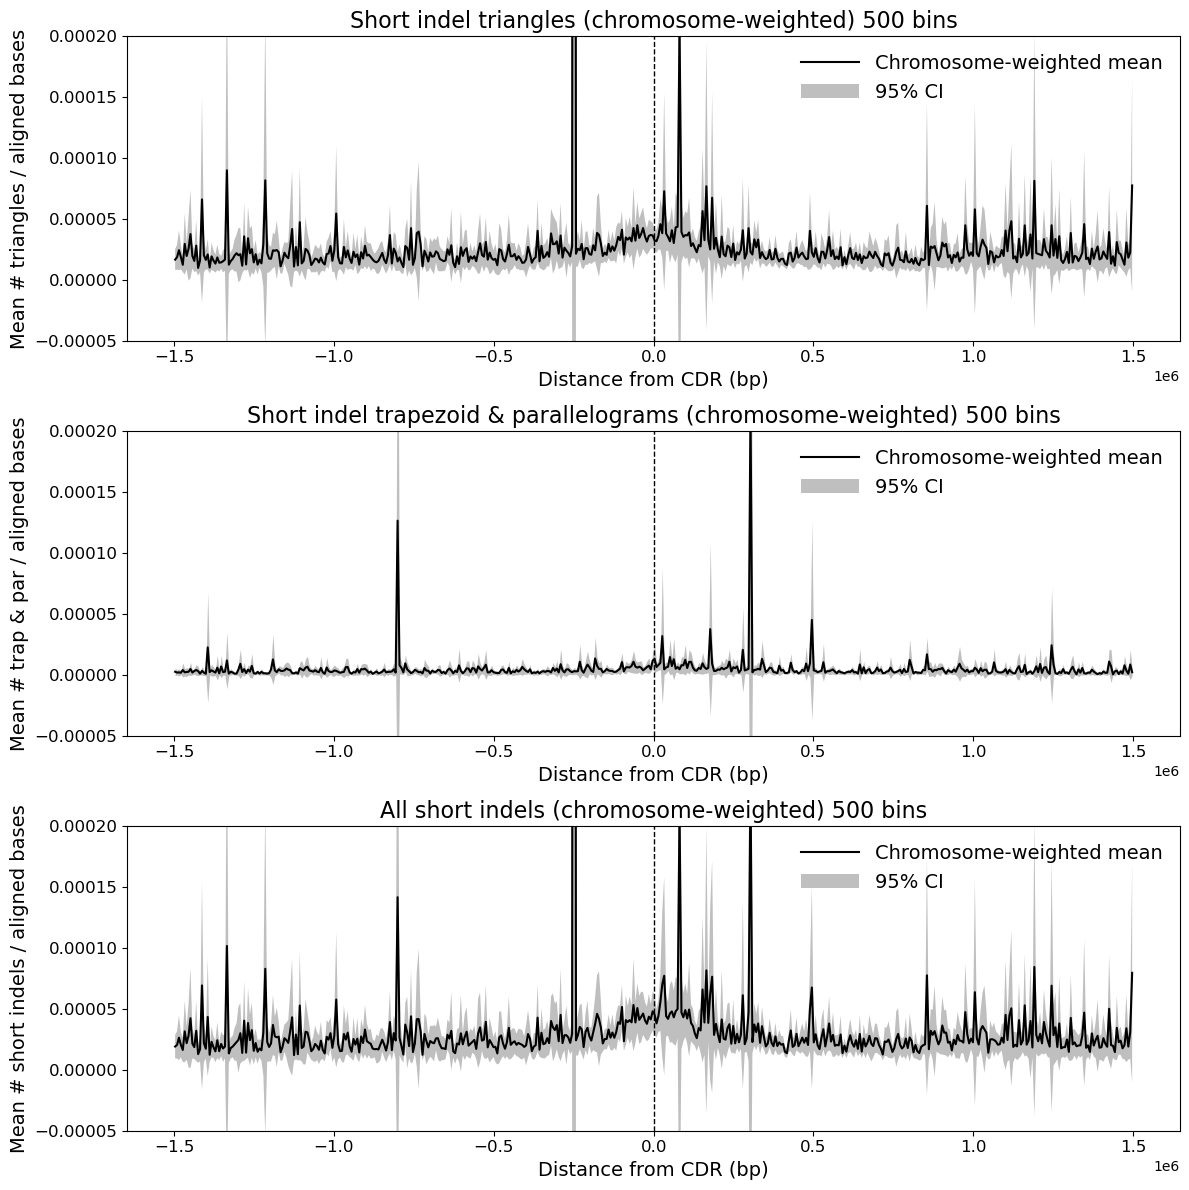

In [ ]:
### Averaging within chrom, then each window plotting the average across chroms 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])


# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = short_indel_10kb_df[short_indel_10kb_df["CDR_start"] != -1].copy()

# ----------------------------
# Drop chromosomes with < 20 sample pairs
# ----------------------------

df["sample_pair"] = (
    df[["sample1", "sample2"]]
    .astype(str)
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

pair_counts = (
    df[["chr", "sample_pair"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
)

valid_chroms = pair_counts[pair_counts >= 20].index

df = df[df["chr"].isin(valid_chroms)].copy()


df["trap_par_rate"] = (
    df["par_rate_aln_bases"] + df["trap_rate_aln_bases"]
)

rate_columns = [
    "tri_rate_aln_bases",
    "trap_par_rate",
    "all_rate_aln_bases"
]

# Clean invalid values
df[rate_columns] = df[rate_columns].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Plot labels
# ----------------------------
plot_titles = [
    "Short indel triangles (chromosome-weighted) 500 bins",
    "Short indel trapezoid & parallelograms (chromosome-weighted) 500 bins",
    "All short indels (chromosome-weighted) 500 bins"
]
y_labels = [
    "Mean # triangles / aligned bases",
    "Mean # trap & par / aligned bases",
    "Mean # short indels / aligned bases"
]

# ----------------------------
# 3. Create subplots
# ----------------------------
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 12))

for ax, rate_col, title, y_label in zip(
    axes, rate_columns, plot_titles, y_labels
):

    # ------------------------------------------------
    # Step 1: mean per chromosome per bin
    # ------------------------------------------------
    chrom_bin_means = (
        df.groupby(["distance_bin", "chr"])
          .agg(chrom_mean=(rate_col, "mean"))
          .reset_index()
    )

    # ------------------------------------------------
    # Step 2: chromosome-weighted genome average
    # ------------------------------------------------
    agg = (
        chrom_bin_means
        .groupby("distance_bin")
        .agg(
            mean_rate=("chrom_mean", "mean"),
            std_rate=("chrom_mean", "std"),
            n_chroms=("chrom_mean", "count")
        )
        .reset_index()
        .sort_values("distance_bin")
    )

    # ------------------------------------------------
    # Step 3: t-distribution CI (chromosomes = n)
    # ------------------------------------------------
    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    # ------------------------------------------------
    # Plot mean
    # ------------------------------------------------
    ax.plot(
        agg["distance_bin"],
        agg["mean_rate"],
        color="black",
        linewidth=1.5,
        label="Chromosome-weighted mean"
    )

    # Plot CI band (require ≥2 chromosomes)
    valid = agg["n_chroms"] >= 2
    ax.fill_between(
        agg.loc[valid, "distance_bin"],
        agg.loc[valid, "ci_low"],
        agg.loc[valid, "ci_high"],
        color="black",
        alpha=0.25,
        linewidth=0,
        label="95% CI"
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label,fontsize=14)
    ax.set_xlabel("Distance from CDR (bp)",fontsize=14)
    ax.set_title(title,fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=12)

    ax.legend(
        frameon=False,
        fontsize=14,
        handlelength=3,
        loc="upper right"
    )   
    ax.set_ylim(-0.00005,0.0002)
plt.tight_layout()
plt.show()

### SNVs, 10 kb

In [27]:
def load_matching_beds_SNVs(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 6, 7, 8, 9,10,16,17]
    col_names = [
        "contig",
        "window_start",
        "window_end",
        "SNV_counts",
        "SNV_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance",
        "aligned_bases"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [29]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/SNVs_pairwise_10kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds_SNVs(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SNV_raw_10kb_df = pd.concat(all_chrom_dfs, ignore_index=True)
# Add aligned bases 
SNV_raw_10kb_df["SNV_rate_aln_bases"] = SNV_raw_10kb_df["SNV_counts"] / SNV_raw_10kb_df["aligned_bases"]

SNV_raw_10kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


,contig,window_start,window_end,SNV_counts,SNV_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,aligned_bases,sample1,sample2,chr,both_pairs_CDR,SNV_rate_aln_bases
0,NA19909#2#CM094132.1,121895768,121905768,9,0.0009,NA19909#2#CM094132.1,124208369,124227486,CDR,2302602,7625,HG01784.1,NA19909.2,chr1,True,0.001180
1,NA19909#2#CM094132.1,121905768,121915768,4,0.0004,NA19909#2#CM094132.1,124208369,124227486,CDR,2292602,10000,HG01784.1,NA19909.2,chr1,True,0.000400
2,NA19909#2#CM094132.1,121915768,121925768,8,0.0008,NA19909#2#CM094132.1,124208369,124227486,CDR,2282602,9901,HG01784.1,NA19909.2,chr1,True,0.000808
3,NA19909#2#CM094132.1,121925768,121935768,7,0.0007,NA19909#2#CM094132.1,124208369,124227486,CDR,2272602,7382,HG01784.1,NA19909.2,chr1,True,0.000948
4,NA19909#2#CM094132.1,121935768,121945768,10,0.0010,NA19909#2#CM094132.1,124208369,124227486,CDR,2262602,6600,HG01784.1,NA19909.2,chr1,True,0.001515


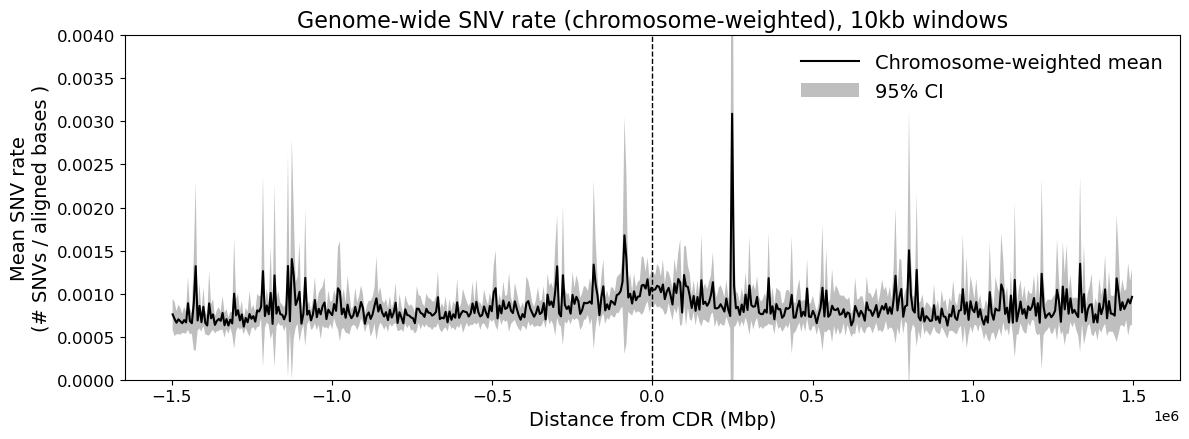

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

# ----------------------------
# Drop chromosomes with < 10 sample pairs
# ----------------------------

df["sample_pair"] = (
    df[["sample1", "sample2"]]
    .astype(str)
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

pair_counts = (
    df[["chr", "sample_pair"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
)

valid_chroms = pair_counts[pair_counts >= 20].index

df = df[df["chr"].isin(valid_chroms)].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# 3. Chromosome-weighted averaging
# ----------------------------

# Step 1: mean SNV rate per chromosome per bin
chrom_bin_means = (
    df.groupby(["distance_bin", "chr"])
      .agg(chrom_mean=("SNV_rate_aln_bases", "mean"))
      .reset_index()
)

# Step 2: average across chromosomes (equal chrom weight)
agg = (
    chrom_bin_means
    .groupby("distance_bin")
    .agg(
        mean_rate=("chrom_mean", "mean"),
        std_rate=("chrom_mean", "std"),
        n_chroms=("chrom_mean", "count")
    )
    .reset_index()
    .sort_values("distance_bin")
)

# ----------------------------
# 4. Confidence intervals (t distribution)
# ----------------------------
agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

# ----------------------------
# 5. Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4.5))

# Mean line
ax.plot(
    agg["distance_bin"],
    agg["mean_rate"],
    color="black",
    linewidth=1.5,
    label="Chromosome-weighted mean"
)

# CI band (require ≥2 chromosomes)
valid = agg["n_chroms"] >= 2
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "ci_low"],
    agg.loc[valid, "ci_high"],
    color="black",
    alpha=0.25,
    linewidth=0,
    label="95% CI"
)

ax.set_xlabel("Distance from CDR (Mbp)",fontsize=14)
ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases )",fontsize=14)
ax.set_title(
    "Genome-wide SNV rate (chromosome-weighted), 10kb windows",fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0,0.004)
ax.legend(
    frameon=False,
    fontsize=14,
    handlelength=3
)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

#ax.set_ylim(0,0.0025)
plt.tight_layout()
plt.show()

In [40]:
import numpy as np
import pandas as pd

# ----------------------------
# Filter chromosomes
# ----------------------------
df = df[df["chr"].isin(valid_chroms)].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace(
    [np.inf, -np.inf], np.nan
)

# ----------------------------
# Assign numeric bin centers
# ----------------------------
df["distance_bin"] = (
    pd.cut(
        df["CDR_distance"],
        bins=bins,
        labels=bin_centers,
        include_lowest=True
    )
    .astype(float)
)

# ----------------------------
# Step 1: per-chromosome stats per bin
# ----------------------------
chrom_bin_means = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_mean=("SNV_rate_aln_bases", "mean"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# Step 2: chromosome-weighted mean per bin
# ----------------------------
agg = (
    chrom_bin_means
    .groupby("distance_bin")
    .agg(
        mean_rate=("chrom_mean", "mean"),
        std_rate=("chrom_mean", "std"),
        n_chroms=("chrom_mean", "count")
    )
    .reset_index()
    .sort_values("distance_bin")
)

# ----------------------------
# Identify the bin with the highest rate
# ----------------------------
# restrict to bins within 1 Mb of CDR
within_1mb = agg[np.abs(agg["distance_bin"]) < 1_000_000]

max_idx = within_1mb["mean_rate"].idxmax()
max_bin_row = within_1mb.loc[max_idx]

max_bin = max_bin_row["distance_bin"]
max_rate = max_bin_row["mean_rate"]

print(f"Max-rate bin center (<1 Mb): {max_bin}")
print(f"Chromosome-weighted mean rate: {max_rate}")
print(f"Number of chromosomes contributing: {int(max_bin_row['n_chroms'])}")

# ----------------------------
# Per-chromosome stats for that bin (float-safe)
# ----------------------------
per_chrom = (
    chrom_bin_means[
        np.isclose(
            chrom_bin_means["distance_bin"].values,
            max_bin,
            rtol=0,
            atol=1e-9
        )
    ]
    .sort_values("chrom_mean", ascending=False)
)

print("\nPer-chromosome stats for this bin:")
print(
    per_chrom[["chr", "chrom_mean", "n_windows"]]
    .to_string(index=False)
)

# ----------------------------
# Optional sanity check
# ----------------------------
print("\nSanity check:")
print("Expected chromosomes:", int(max_bin_row["n_chroms"]))
print("Recovered chromosomes:", per_chrom.shape[0])



Max-rate bin center (<1 Mb): 252000.0
Chromosome-weighted mean rate: 0.0030030241429373295
Number of chromosomes contributing: 21

Per-chromosome stats for this bin:
  chr  chrom_mean  n_windows
chr17    0.042029         24
chr22    0.004777        126
chr10    0.001803        137
 chr2    0.001501        551
 chr1    0.001362        393
chr19    0.001215        289
chr11    0.001092        603
chr12    0.000935        216
 chr7    0.000907         72
chr13    0.000900          1
chr14    0.000832        128
 chrX    0.000751        213
 chr5    0.000749        157
 chr9    0.000664        260
chr20    0.000659        239
chr21    0.000614         15
chr15    0.000576         51
chr16    0.000513         43
 chr8    0.000407        344
 chr6    0.000390         32
 chr3    0.000387         47

Sanity check:
Expected chromosomes: 21
Recovered chromosomes: 21


In [44]:
# Subset to chr17
df_chr17 = df[df["chr"] == "chr17"].copy()

# Clean invalid rates (if not already done)
df_chr17["SNV_rate"] = df_chr17["SNV_rate"].replace(
    [np.inf, -np.inf], np.nan
)

# Top 5 windows by SNV_rate
top5 = (
    df_chr17
    .sort_values("SNV_rate", ascending=False)
    .head(20)
)

print("Top 5 windows by SNV_rate on chr17:")
print(top5.to_string(index=False))



Top 5 windows by SNV_rate on chr17:
                     contig  window_start  window_end  SNV_counts  SNV_rate                  CDR_contig  CDR_start  CDR_end CDR_status  CDR_distance  aligned_bases   sample1   sample2   chr  both_pairs_CDR  SNV_rate_aln_bases  distance_bin
HG01123#2#JAGYYY020000044.1      25333596    25343596         320    0.0320 HG01123#2#JAGYYY020000044.1   25450648 25472182        CDR        107053           8365 HG00320.2 HG01123.2 chr17            True            0.038255      108000.0
HG01123#2#JAGYYY020000044.1      25333596    25343596         318    0.0318 HG01123#2#JAGYYY020000044.1   25450648 25472182        CDR        107053           8365 HG00232.1 HG01123.2 chr17            True            0.038016      108000.0
HG01123#2#JAGYYY020000044.1      25333596    25343596         316    0.0316 HG01123#2#JAGYYY020000044.1   25450648 25472182        CDR        107053           8365 HG00140.1 HG01123.2 chr17            True            0.037776      108000.0
HG00

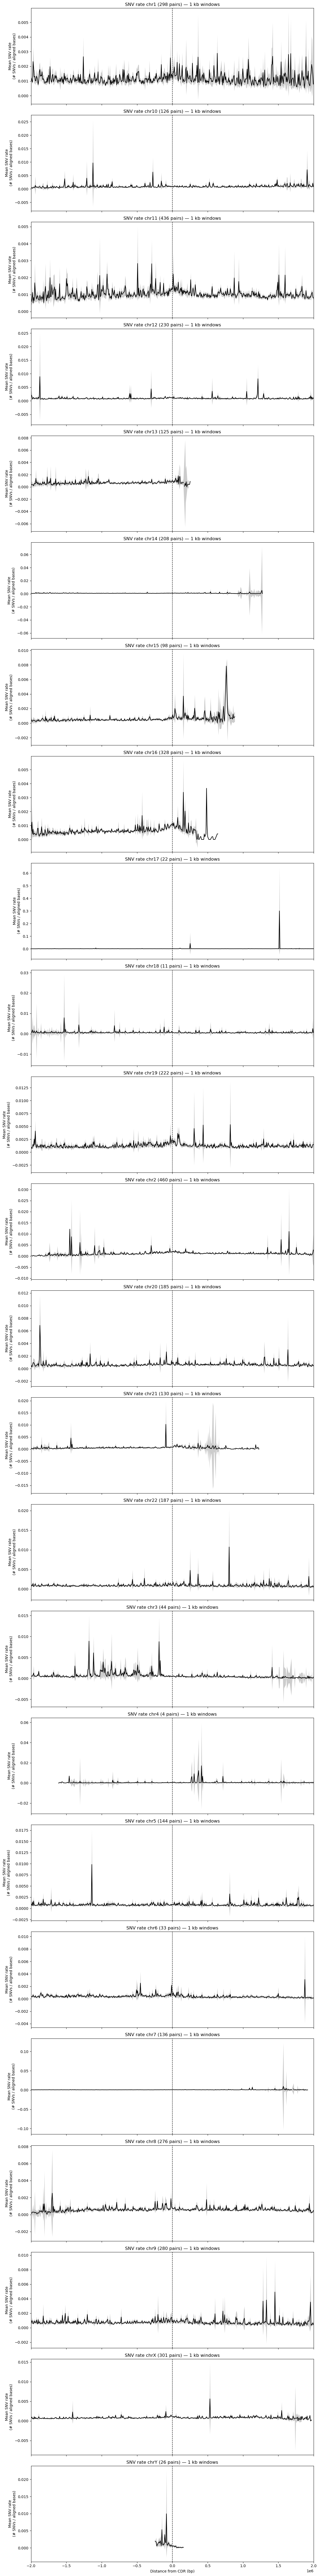

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05
window_range = 2_000_000
n_bins = 500

# ----------------------------
# Filter for valid CDR positions
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace(
    [np.inf, -np.inf], np.nan
)

# ----------------------------
# Define signed-distance bins
# ----------------------------
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Chromosomes
# ----------------------------
chromosomes = sorted(df["chr"].unique())

pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(
    len(chromosomes), 1,
    figsize=(12, 4 * len(chromosomes)),
    sharex=True
)

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    chrom_df = df[df["chr"] == chrom]

    # ---- aggregate per bin ----
    agg = (
        chrom_df
        .groupby("distance_bin")
        .agg(
            mean_rate=("SNV_rate_aln_bases", "mean"),
            std_rate=("SNV_rate_aln_bases", "std"),
            n=("SNV_rate_aln_bases", "count")
        )
        .reset_index()
        .sort_values("distance_bin")
    )

    # ---- CI computation ----
    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    # ---- mean line ----
    ax.plot(
        agg["distance_bin"],
        agg["mean_rate"],
        color="black",
        linewidth=1.5
    )

    # ---- CI band (n ≥ 2) ----
    valid = agg["n"] >= 2
    ax.fill_between(
        agg.loc[valid, "distance_bin"],
        agg.loc[valid, "ci_low"],
        agg.loc[valid, "ci_high"],
        color="grey",
        alpha=0.4,
        linewidth=0
    )

    # ---- formatting ----
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlim(-2_000_000, 2_000_000)
    ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases)")

    n_pairs = pair_counts.get(chrom, 0)
    ax.set_title(f"SNV rate {chrom} ({n_pairs} pairs) — 1 kb windows")

axes[-1].set_xlabel("Distance from CDR (bp)")

plt.tight_layout()
plt.show()